In [2]:
# %pip install jupyter_bokeh -q
%pip install python-dotenv -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from dotenv import load_dotenv
import requests
import json
import numpy as np
import pandas as pd

# packages for widgets and interactive map:
from IPython.display import display, HTML, clear_output


#packages for geo-processing:
import geopandas as gpd
import rasterio
import rioxarray

# packages for visualisation
import geoviews as gv
import hvplot.xarray
import holoviews as hv
import panel as pn


load_dotenv()
hv.extension('plotly')
os.environ['AWS_ACCESS_KEY_ID'] = 'your_access_key'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'your_secret_key'

/usr/local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# Function to list all .tif files in the specified directory
def list_tif_files(path):
    return [f for f in os.listdir(path) if f.endswith('.tif')]

# Function to load and display the selected .tif file
def load_and_display_tif(filename):
    filepath = os.path.join(outpath, filename)
    img = gv.util.from_xarray(rioxarray.open_rasterio(filepath).rio.reproject('EPSG:3857'))
    
    # Define map tiles and create the map image
    map_tiles = gv.tile_sources.EsriImagery().opts(width=1000, height=600)
    map_img = gv.Image(img, kdims=['x', 'y']).opts(cmap='viridis', title=filename)
    map_combo = map_tiles * map_img
    
    return map_combo

In [5]:
def get_access_token(url):
    try:
        payload = {
            'grant_type': 'password',
            'username': os.getenv('GFW_USERNAME'),
            'password': os.getenv('GFW_PASSWORD'),
            'scope': ''
        }
        response = requests.post(url, data=payload)
        response.raise_for_status()
        return response.json()  # Returns the access token
    except Exception as err:
        # General exception handling for unexpected errors
        return f"An error occurred: {err}"
    



Get Auth0 authorisation token

In [6]:
token_url = "https://data-api.globalforestwatch.org/auth/token"
create_api_url = "https://data-api.globalforestwatch.org/auth/apikey"


In [7]:
access_token_info = get_access_token(token_url)
auth_token = access_token_info['data']['access_token']


Get API key

Your API key will expire after 1 year. 

To create an API key, you will need to make an authenticated request with your auth token with details about your application. Send a POST request to the /auth/apikey endpoint that includes a JSON object with alias, email, organization, and domain properties in the body.


In [8]:
# #the url is the api endpoint this payload will go to
# def create_api_key(url, auth_token): 
#     try:
#         headers = {
#             'Authorization': f'Bearer {auth_token}',
#             'Content-Type': 'application/json'
#         }
#         payload = {
#             'alias': 'jenna-test-01',  # Nickname for API Key
#             'organization': 'Sensand',  # Name of organization or website, corrected field name
#             'email': os.getenv('GFW_EMAIL'),  # Email address of POC
#             'domains': [],  # List of domains which can be used this API key
#             'never_expires': False  # Correct boolean value
#         }
#         response = requests.post(url, json=payload, headers=headers)
#         response.raise_for_status()
#         return response.json()
#     except Exception as err:
#         return f"An error occurred: {err}"

# # Assuming create_api_url and auth_token are defined elsewhere
# get_api_key = create_api_key(create_api_url, auth_token)


Use APi key to make data requests

To make most requests to the GFW Data API, you will need to include an API key in a custom header named x-api-key

In [9]:
datasets_url = "https://data-api.globalforestwatch.org/datasets"
apikey = os.getenv('GFW_APIKEY')

def get_gfw_datasets(url, headers=None):
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.json()
    except Exception as err:
        return f"An error occured: {err}"
    
result = get_gfw_datasets(datasets_url, headers = {'Authorization': f'{apikey}'})

datasets = result.get('data') if result else None
if datasets:
    for dataset in datasets:
        print(f"Dataset name: {dataset['dataset']}")
else:
    print("No datasets found or an error occurred.")

Dataset name: anika_radd_test
Dataset name: arg_native_forest_land_plan
Dataset name: arg_otbn_forest_loss
Dataset name: berkeley_earth_temp_anomaly_2000_2020
Dataset name: birdlife_alliance_for_zero_extinction_sites
Dataset name: birdlife_biodiversity_intactness
Dataset name: birdlife_biodiversity_significance
Dataset name: birdlife_endemic_bird_areas
Dataset name: birdlife_key_biodiversity_areas
Dataset name: cartocritica_mex_protected_areas_2016
Dataset name: ci_biodiversity_hotspots
Dataset name: cifor_peatlands
Dataset name: cities_boundaries_test
Dataset name: clark_labs_tropical_pond_aquaculture_1999
Dataset name: clark_labs_tropical_pond_aquaculture_2014
Dataset name: clark_labs_tropical_pond_aquaculture_2018
Dataset name: clark_labs_tropical_pond_aquaculture_change_1999_2014
Dataset name: clark_labs_tropical_pond_aquaculture_change_1999_2018
Dataset name: clark_labs_tropical_pond_aquaculture_change_2014_2018
Dataset name: conafor_mex_forest_zoning
Dataset name: dan_test
Datase

In [10]:
# gadm__glad__iso_weekly_alerts, gadm__glad__adm2_weekly_alerts, 
target_dataset = "umd_tree_cover_loss"
dataset_url = f'https://data-api.globalforestwatch.org/dataset/{target_dataset}'

def get_selected_gfw_dataset(dataset_url, headers=None):
    try:
        url = f'https://data-api.globalforestwatch.org/dataset/{target_dataset}'
        
        response = requests.get(dataset_url, headers=headers)
        response.raise_for_status()
        return response.json()
    except Exception as err:
        return f"An error occured: {err}"
    
result = get_selected_gfw_dataset(dataset_url, headers = {'Authorization': f'{apikey}'})

print(result['data']['dataset'])
print(result['data']['is_downloadable'])


umd_tree_cover_loss
True


<Axes: >

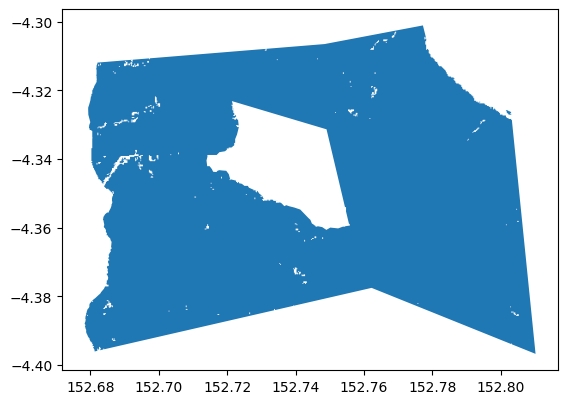

In [13]:
# Query data for a specific AOI

input_geom = "/workspace/notebooks/sandbox/data/input-data/carbon-projects/niht-topaiyo-dissolved-boundaries.geojson"

geom = gpd.read_file(input_geom)


In [12]:
# # Create the dropdown menu
# tif_files = list_tif_files(outpath)

# dropdown = pn.widgets.Select(name='Select a .tif file', options=tif_files)

# # Panel DynamicMap to update the map based on the dropdown selection
# @pn.depends(dropdown.param.value)
# def update_map(selected_file):
#     return load_and_display_tif(selected_file)

# # Layout using Panel
# layout = pn.Column(
#     pn.Row(pn.Column('## Geodata file viewer', dropdown)),
#     update_map
# )

# # Display the Panel dashboard
# layout.servable()